# Improving the DQN algorithm using Double Q-Learning 
> Notes on improving the DQN algorithm using Double Q-learning.

- branch: 2020-04-11-double-dqn
- badges: true
- image: images/double-dqn-figure-2.png
- comments: true
- author: David R. Pugh
- categories: [pytorch, deep-reinforcement-learning, deep-q-networks]

I am continuing to work my way through the [Udacity](https://www.udacity.com/) [*Deep Reinforcement Learning Nanodegree*](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). In this blog post I discuss and implement the Double DQN algorithm from [*Deep Reinforcement Learning with Double Q-Learning*](https://arxiv.org/abs/1509.06461) (Van Hasselt et al 2015). The Double DQN algorithm is a minor, but important, modification of the original DQN algorithm that I covered in a [previous post](https://davidrpugh.github.io/stochastic-expatriate-descent/pytorch/deep-reinforcement-learning/deep-q-networks/2020/04/03/deep-q-networks.html).

The Van Hasselt et al 2015 paper makes several important contributions. 

1. Demonstration of how Q-learning can be overly optimistic in large-scale, even 
   deterministic, problems due to the inherent estimation errors of learning. 
2. Demonstration that over-estimations are more common and severe in practice than previously 
   acknowledged. 
3. Implementation of Double Q-learning called Double DQN that extends, with minor 
   modifications, the popular DQN algorithm and that can be used at scale to successfully 
   reduce over-estimations with the result being more stable and reliable learning.
4. Demonstation that Double DQN finds better policies by obtaining new state-of-the-art 
   results on the Atari 2600 dataset.
   
## Why does Q-learning over-estimate Q-values?

No matter what type of function approximation scheme used to approximate the action-value function $Q$ there will always be approximation error. The presence of the max operator in the Bellman equation used to compute the $Q$-values means that the approximate $Q$-values will almost always be strictly greater than the corresponding $Q$ value from the true action-value function (i.e., the approximation errors will almost always be positive). This potentially significant source of bias can impede learning and is often exacerbated by the use of flexible, non-linear function approximators such as neural networks. By explicitly separating action selection from action evaluation, double Q-Learning allows each step to use a different function approximator resulting in a better overall approximation of the action-value function. Figure 2 (with caption) below, which is taken from Van Hasselt et al 2015, summarizes these ideas. See the [paper](https://arxiv.org/pdf/1509.06461.pdf) for more details.

![](my_icons/double-dqn-figure-2.png)
    
## Implementing the Double DQN algorithm

The key idea behind Double Q-learning is to reduce over-estimations of Q-values by separating the selection of actions from the evaluation of those actions so that a different Q-network can be used in each step. When applying Double Q-learning to extend the DQN algorithm one can use the online Q-network, $Q(S, a; \theta)$, to select the actions and then the target Q-network, $Q(S, a; \theta^{-})$, to evaluate the selected actions.

Before implement the Double DQN algorithm, I am going to re-implement the Q-learning update from the DQN algorithm in a way that explicitly separates action selection from action evaluation. Once I have implemented this new version of Q-learning, implementing the Double DQN algorithm will be much easier. Formally separating action selection from action evaluation involves re-writing the Q-learning Bellman equation as follows.

$$ Y_t^{DQN} = R_{t+1} + \gamma Q\big(S_{t+1}, \underset{a}{\mathrm{argmax}}\ Q(S_{t+1}, a; \theta_t); \theta_t\big) $$

In Python this can be implemented as three separate functions.

In [3]:
import torch
from torch import nn


def select_greedy_actions(states: torch.Tensor, q_network: nn.Module) -> torch.Tensor:
    """Select the greedy action for the current state given some Q-network."""
    _, actions = q_network(states).max(dim=1, keepdim=True)
    return actions


def evaluate_selected_actions(states: torch.Tensor,
                              actions: torch.Tensor,
                              rewards: torch.Tensor,
                              dones: torch.Tensor,
                              gamma: float,
                              q_network: nn.Module) -> torch.Tensor:
    """Compute the Q-values by evaluating the actions given the current states and Q-network."""
    next_q_values = q_network(states).gather(dim=1, index=actions)        
    q_values = rewards + (self._gamma * next_q_values * (1 - dones))
    return q_values


def q_learning_update(states: torch.Tensor,
                      rewards: torch.Tensor,
                      dones: torch.Tensor,
                      gamma: float,
                      q_network: nn.Module) -> torch.Tensor:
    """Q-Learning update with explicitly decoupled action selection and evaluation steps."""
    actions = select_greedy_actions(states, q_network)
    q_values = evaluate_selected_actions(states, actions, rewards, dones, gamma, q_network)
    return q_values



From here it is straight forward to implement the Double DQN algorithm. All I need is a second action-value function. The target network in the DQN architecture provides a natural candidate for the second action-value function. Hasselt et al 2015 suggest using the online Q-network to select the greedy policy actions before using the target Q-network to estimate the value of the selected actions. Once again here are the maths...

$$ Y_t^{DoubleDQN} = R_{t+1} + \gamma Q\big(S_{t+1}, \underset{a}{\mathrm{argmax}}\ Q(S_{t+1}, a; \theta_t), \theta_t^{-}\big) $$

...and here is the the Python implementation.

In [4]:
def double_q_learning_update(states: torch.Tensor,
                             rewards: torch.Tensor,
                             dones: torch.Tensor,
                             gamma: float,
                             q_network_1: nn.Module,
                             q_network_2: nn.Module) -> torch.Tensor:
    """Double Q-Learning uses Q-network 1 to select actions and Q-network 2 to evaluate the selected actions."""
    actions = select_greedy_actions(states, q_network_1)
    q_values = evaluate_selected_actions(states, rewards, actions, dones, gamma, q_network_2)
    return q_values

Note that the function `double_q_learning_update` is almost identical to the `q_learning_update` function above: all that is needed is to introduce a second Q-network parameter, `q_network_2`, to the function. This second Q-network will be use to evaluate the actions chosen using the original Q-network parameter, now called `q_network_1`.

## Solving the `LunarLander-v2` environment

In the rest of this blog post I will use the Double DQN algorithm to train an agent to solve the [LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/) environment from [OpenAI](https://openai.com/) and the compare it to the the results obtained using the vanilla DQN algorithm.

In this environment the landing pad is always at coordinates (0,0). The reward for moving the lander from the top of the screen to landing pad and arriving at zero speed is typically between 100 and 140 points. Firing the main engine is -0.3 points each frame (so the lander is incentivized to fire the engine as few times possible). If the lander moves away from landing pad it loses reward (so the lander is incentived to land in the designated landing area). The lander is also incentived to land "gracefully" (and not crash in the landing area!).

A training episode finishes if the lander crashes (-100 points) or comes to rest (+100 points). Each leg with ground contact receives and additional +10 points. The task is considered "solved" if the lander is able to achieve 200 points (I will actually be more stringent and define "solved" as achieving over 200 points on average in the most recent 100 training episodes).

### Action Space 

There are four discrete actions available: 

0. Do nothing.
1. Fire the left orientation engine.
2. Fire main engine.
3. Fire the right orientation engine.

### Colab specific environment setup

If you are playing around with this notebook on Google Colab, then you will need to run the following cell in order to install the required OpenAI dependencies into the environment.

In [ ]:
!pip install gym[box2d]==0.17.*

### Making my code more maintainable

In order to make the code used in this and in my previous blog post more maintainable for future posts, I have moved the various class definitions and training functions in my previous post out of Jupyter notebooks and into scripts. The [`agents.py`](https://github.com/davidrpugh/stochastic-expatriate-descent/blob/2020-04-11-double-dqn/_notebooks/agents.py) scripts contains the various agent classes, in particular the `DeepQAgent` class which implements both the DQN and Double DQN algorithms; the [`experience_replay.py`](https://github.com/davidrpugh/stochastic-expatriate-descent/blob/2020-04-11-double-dqn/_notebooks/experience_replay.py) script containing the `Experience` and `ExperienceReplayBuffer` classes; and the [`training.py`](https://github.com/davidrpugh/stochastic-expatriate-descent/blob/2020-04-11-double-dqn/_notebooks/training.py) script contains the functions that train an `agents.Agent` to solve some `gym.Env` environment.

In [33]:
import gym

import agents  # module containing the DeepQAgent class  
import training  # module containing the training functions

env = gym.make('LunarLander-v2')
_ = env.seed(42)

/Users/pughdr/Research/stochastic-expatriate-descent/env/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Creating a `DeepQAgent`

#### Epsilon decay schedule

As was the case with the DQN algorithm, when using the Double DQN algorithm the agent chooses its action using an $\epsilon$-greedy policy. When using an $\epsilon$-greedy policy, with probability $\epsilon$, the agent explores the state space by choosing an action uniformly at random from the set of feasible actions; with probability $1-\epsilon$, the agent exploits its current knowledge by choosing the optimal action given that current state. 

As the agent learns and acquires additional knowledge about it environment it makes sense to *decrease* exploration and *increase* exploitation by decreasing $\epsilon$. In practice, it isn't a good idea to decrease $\epsilon$ to zero; instead one typically decreases $\epsilon$ over time according to some schedule until it reaches some minimum value.

In [2]:
def power_decay_schedule(episode_number: int,
                         decay_factor: float,
                         minimum_epsilon: float) -> float:
    """Power decay schedule found in other practical applications."""
    return max(decay_factor**episode_number, minimum_epsilon)

_epsilon_decay_schedule_kwargs = {
    "decay_factor": 0.99,
    "minimum_epsilon": 1e-2,
}
epsilon_decay_schedule = lambda n: power_decay_schedule(n, **_epsilon_decay_schedule_kwargs)

#### Choosing an optimizer

As is the case in training any neural network, the choice of optimizer and the tuning of its hyper-parameters (in particular the learning rate) is important. Here I am going to use the [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) optimizer. In my previous post on the DQN algorithm I used [RMSProp](https://pytorch.org/docs/stable/optim.html#torch.optim.RMSProp). In my experiments I found that the Adam optimizer significantly improves the efficiency and stability of both the Double DQN and DQN algorithms compared with RMSProp (on this task at least!). 

In [3]:
from torch import optim


_optimizer_kwargs = {
    "lr": 1e-3,
    "betas": (0.9, 0.999),
    "eps": 1e-08,
    "weight_decay": 0,
    "amsgrad": False,
}
optimizer_fn = lambda parameters: optim.Adam(parameters, **_optimizer_kwargs)

### Training the `DeepQAgent` using Double DQN

Now I am finally ready to train the `deep_q_agent`. The target score for the `LunarLander-v2` environment is 200 points on average for at least 100 consecutive episodes. If the `deep_q_agent` is able to "solve" the environment, then training will terminate early.

In [34]:
_agent_kwargs = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 1e-3,
    "gamma": 0.99,
    "update_frequency": 4,
    "double_dqn": True,  # True uses Double DQN; False uses DQN 
    "seed": None,
}
double_dqn_agent = agents.DeepQAgent(**_agent_kwargs)

double_dqn_scores = training.train(doube_dqn_agent,
                                   env,
                                   "double-dqn-checkpoint.pth",
                                   number_episodes=2000,
                                   target_score=200)

Episode 100	Average Score: -136.37
Episode 200	Average Score: -80.72
Episode 300	Average Score: -42.48
Episode 400	Average Score: 44.46
Episode 500	Average Score: 108.45
Episode 600	Average Score: 193.84

Environment solved in 609 episodes!	Average Score: 201.15


### Training the `DeepQAgent` using DQN

Next I will create another `DeepQAgent` and train it using the original DQN algorithm for comparison.

In [36]:
_agent_kwargs = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 1e-3,
    "gamma": 0.99,
    "update_frequency": 4,
    "double_dqn": False,  # True uses Double DQN; False uses DQN 
    "seed": None,
}
dqn_agent = agents.DeepQAgent(**_agent_kwargs)

In [37]:
dqn_scores = training.train(dqn_agent,
                            env,
                            "dqn-checkpoint.pth",
                            number_episodes=2000,
                            target_score=200)

Episode 100	Average Score: -188.97
Episode 200	Average Score: -141.91
Episode 300	Average Score: -61.08
Episode 400	Average Score: -41.62
Episode 500	Average Score: -28.62
Episode 600	Average Score: -19.19
Episode 700	Average Score: -42.72
Episode 800	Average Score: 119.68
Episode 900	Average Score: 186.27

Environment solved in 925 episodes!	Average Score: 202.67


### Comparing DQN and Double DQN

To make it a bit easier to compare the overall performance of the two algorithms I will now re-train both agents for the same number of episodes (rather than training for the minimum number of episodes required to achieve a target score).

In [11]:
_agent_kwargs = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 1e-3,
    "gamma": 0.99,
    "update_frequency": 4,
    "double_dqn": True,
    "seed": None,
}
double_dqn_agent = agents.DeepQAgent(**_agent_kwargs)

double_dqn_scores = training.train(double_dqn_agent,
                                   env,
                                   "double-dqn-checkpoint.pth",
                                   number_episodes=2000,
                                   target_score=float("inf"))

Episode 100	Average Score: -154.91
Episode 200	Average Score: -93.57
Episode 300	Average Score: -52.90
Episode 400	Average Score: 21.00
Episode 500	Average Score: 63.61
Episode 600	Average Score: 124.04
Episode 700	Average Score: 213.36
Episode 800	Average Score: 196.64
Episode 900	Average Score: 200.42
Episode 1000	Average Score: 233.95
Episode 1100	Average Score: 242.40
Episode 1200	Average Score: 252.33
Episode 1300	Average Score: 214.17
Episode 1400	Average Score: 225.87
Episode 1500	Average Score: 245.65
Episode 1600	Average Score: 259.11
Episode 1700	Average Score: 253.96
Episode 1800	Average Score: 255.25
Episode 1900	Average Score: 255.18
Episode 2000	Average Score: 254.36


In [12]:
_agent_kwargs = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 1e-3,
    "gamma": 0.99,
    "update_frequency": 4,
    "double_dqn": False,
    "seed": None,
}
dqn_agent = agents.DeepQAgent(**_agent_kwargs)

dqn_scores = training.train(dqn_agent,
                            env,
                            "dqn-checkpoint.pth",
                            number_episodes=2000,
                            target_score=float("inf"))

Episode 100	Average Score: -163.32
Episode 200	Average Score: -112.35
Episode 300	Average Score: -47.40
Episode 400	Average Score: 9.72
Episode 500	Average Score: 115.13
Episode 600	Average Score: 168.85
Episode 700	Average Score: 217.28
Episode 800	Average Score: 144.49
Episode 900	Average Score: 202.26
Episode 1000	Average Score: 224.12
Episode 1100	Average Score: 226.08
Episode 1200	Average Score: 231.65
Episode 1300	Average Score: 242.66
Episode 1400	Average Score: 255.53
Episode 1500	Average Score: 265.84
Episode 1600	Average Score: 266.04
Episode 1700	Average Score: 262.30
Episode 1800	Average Score: 251.11
Episode 1900	Average Score: 257.42
Episode 2000	Average Score: 252.75


#### Plotting the time series of scores

I can use [Pandas](https://pandas.pydata.org/) to quickly plot the time series of scores along with a 100 episode moving average. Note that training stops as soon as the rolling average crosses the target score.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
dqn_scores = pd.Series(dqn_scores, name="scores")
double_dqn_scores = pd.Series(double_dqn_scores, name="scores")

In [21]:
dqn_scores.describe()

count    2000.000000
mean      163.508939
std       152.089392
min      -500.516422
25%        37.745057
50%       240.134765
75%       264.536588
max       310.643203
Name: scores, dtype: float64

In [22]:
double_dqn_scores.describe()

count    2000.000000
mean      160.496507
std       154.166885
min      -543.465688
25%        47.844408
50%       240.574470
75%       264.805729
max       319.673532
Name: scores, dtype: float64

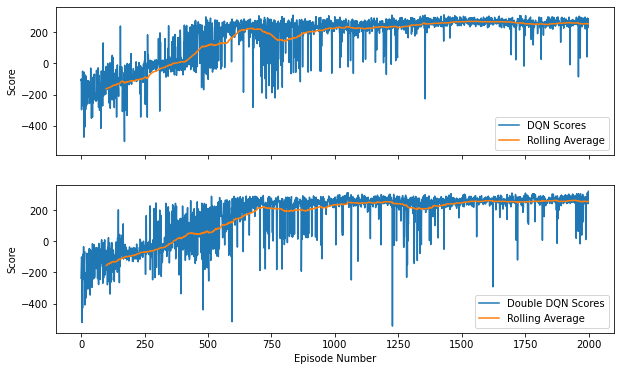

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = dqn_scores.plot(ax=axes[0], label="DQN Scores")
_ = (dqn_scores.rolling(window=100)
               .mean()
               .rename("Rolling Average")
               .plot(ax=axes[0]))
_ = axes[0].legend()
_ = axes[0].set_ylabel("Score")

_ = double_dqn_scores.plot(ax=axes[1], label="Double DQN Scores")
_ = (double_dqn_scores.rolling(window=100)
                      .mean()
                      .rename("Rolling Average")
                      .plot(ax=axes[1]))
_ = axes[1].legend()
_ = axes[1].set_ylabel("Score")
_ = axes[1].set_xlabel("Episode Number")


#### Kernel density plot of the scores

Kernel density plot of scores is bimodal with one mode less than -100 and a second mode greater than 200. The negative mode corresponds to those training episodes where the agent crash landed and thus scored at most -100; the positive mode corresponds to those training episodes where the agent "solved" the task. The kernel density or scores typically exhibits negative skewness (i.e., a fat left tail): there are lots of ways in which landing the lander can go horribly wrong (resulting in the agent getting a very low score) and only relatively few paths to a gentle landing (and a high score). Visually there doesn't seem to be too much of a difference between the distribution of scores between the DQN and Double DQN algorithms.

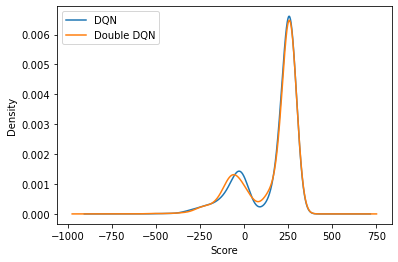

In [18]:
fig, ax = plt.subplots(1,1)
_ = dqn_scores.plot(kind="kde", ax=ax, label="DQN")
_ = double_dqn_scores.plot(kind="kde", ax=ax, label="Double DQN")
_ = ax.set_xlabel("Score")
_ = ax.legend()

## Where to go from here?

In my next post I plan to cover [Prioritized Experience Replay](https://arxiv.org/abs/1509.06461) which improves the sampling scheme used by the `ExperienceReplayBuffer` so as to replay important transitions more frequently which should lead to more efficient learning. 